### Setting up the system for dog vs cat from Kaggle
**Transfer learning** allows us to use a **pre-trained model**, trained on a huge dataset, for our own tasks

In [1]:
!curl https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip -O cats_and_dogs_filtered.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 65.4M  100 65.4M    0     0  26.4M      0  0:00:02  0:00:02 --:--:-- 26.4M
curl: (6) Could not resolve host: cats_and_dogs_filtered.zip


In [2]:
import os 
import zipfile 
import tensorflow as tf 
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras import layers 
from tensorflow.keras import Model 
import matplotlib.pyplot as plt

### Preparing the Dataset
- We first divide the folder contents into the train and validation directories.
- Then, in each of the directories, create a separate directory for cats that contains only cat images, and a separate director for dogs having only dog images.

In [3]:
local_zip = 'cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('./')
zip_ref.close()

base_dir = 'cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

### check if the images have been loaded correctly:

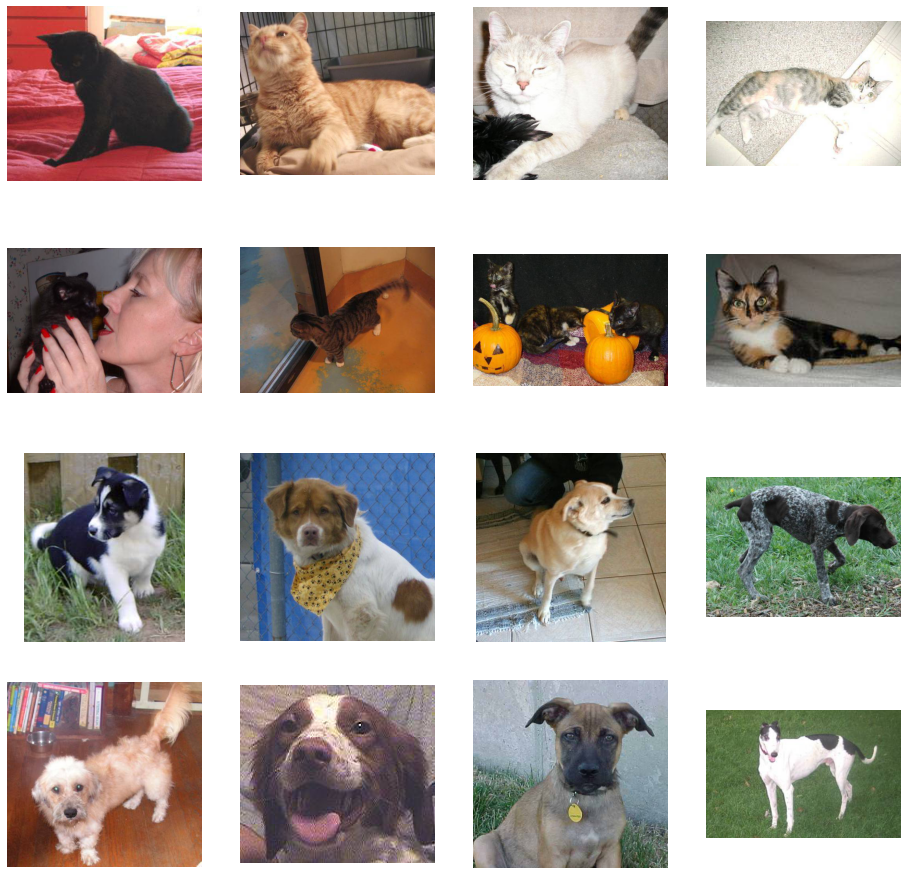

In [4]:
# Set up matplotlib fig, and size it to fit 4x4 pics
import matplotlib.image as mpimg
nrows = 4
ncols = 4

fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)
pic_index = 100
train_cat_fnames = os.listdir( train_cats_dir )
train_dog_fnames = os.listdir( train_dogs_dir )


next_cat_pix = [os.path.join(train_cats_dir, fname) 
                for fname in train_cat_fnames[ pic_index-8:pic_index] 
               ]

next_dog_pix = [os.path.join(train_dogs_dir, fname) 
                for fname in train_dog_fnames[ pic_index-8:pic_index]
               ]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

### Pre-Trained Models for Image Classification - EfficientNet
- EfficientB0 has only 5.3 million parameters 

In [4]:
!pip install -U efficientnet

In [5]:
import efficientnet.keras as efn

### Step 1: Image Augmentation

In [6]:
# Add our data-augmentation parameters to ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255., rotation_range = 40, width_shift_range = 0.2, height_shift_range = 0.2, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1.0/255.)

train_generator = train_datagen.flow_from_directory(train_dir, batch_size = 20, class_mode = 'binary', target_size = (224, 224))

validation_generator = test_datagen.flow_from_directory( validation_dir, batch_size = 20, class_mode = 'binary', target_size = (224, 224))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


### Step 2: Loading the Base Model

In [7]:
base_model = efn.EfficientNetB0(input_shape = (224, 224, 3), include_top = False, weights = 'imagenet')


2023-04-16 16:32:43.232565: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-16 16:32:43.259517: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fdd16238160 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2023-04-16 16:32:43.259534: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version


In [8]:
# freeze the layers
for layer in base_model.layers:
    layer.trainable = False

### Step 3: Build the model: perform these steps at the final layer

In [9]:
x = base_model.output
x = layers.Flatten()(x)
x = layers.Dense(1024, activation="relu")(x)
x = layers.Dropout(0.5)(x)
predictions = layers.Dense(1, activation="sigmoid")(x)
model_final = tf.keras.models.Model(base_model.input, predictions)

### Step 4: Compile and Fit

In [10]:
model_final.compile(tf.keras.optimizers.RMSprop(lr=0.0001, decay=1e-6),loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
# fit the model on our data:

eff_history = model_final.fit_generator(train_generator, validation_data = validation_generator, steps_per_epoch = 100, epochs = 10)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
100/100 [==============================] - 114s 1s/step - loss: 0.4279 - accuracy: 0.8895 - val_loss: 0.0865 - val_accuracy: 0.9760
Epoch 2/10
100/100 [==============================] - 111s 1s/step - loss: 0.2634 - accuracy: 0.9345 - val_loss: 0.1721 - val_accuracy: 0.9720
Epoch 3/10
 20/100 [=====>........................] - ETA: 1:07 - loss: 0.2904 - accuracy: 0.9350

In [ ]:
### There we go – we got a whopping 97% accuracy on our validation set in only 10 epochs. 
### I urge you to try training the larger dataset with EfficientNetB7 and share the results with us